In [32]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
%cd ../..

/home/nassim


In [34]:
from src.conrl import ConRL
from src.qlearning import QLearningAgent
from src.utils import EpisodeStats
from envs.gridworld import GridworldEnv

import itertools
import numpy as np
import pandas as pd
import time
import sys

import matplotlib.pyplot as plt
import matplotlib.collections as mc

%matplotlib inline
plt.style.use('ggplot')
np.set_printoptions(precision=3, linewidth=80)

## ConRL Gridworld

In [35]:
env_shape = (8, 8)
env = GridworldEnv(shape=env_shape)
num_episodes = 200
max_step = 200
action_size = env.action_space.n
state_size = (env.observation_space.n, )

q_params = {
    "gamma": 0.5,
    "alpha": 1,
    "alpha_decay_rate": 0,
    "min_alpha": 0.1,
    "epsilon": 0.1,
    "epsilon_decay_rate": 0,
    "min_epsilon": 0.1
}

mlgng_params = {
    "ndim": 1, 
    "e_w":0.5, 
    "e_n":0.1, 
    "l":10, 
    "a":0.5, 
    "b":1-0.05, # Java impl. does it like this
    "k":1000.0, 
    "max_nodes": 4, 
    "max_age": 10
}

In [36]:
stats = EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes),
        selector_dist=np.zeros((num_episodes, max_step)).astype(int))

conrl = ConRL(action_size=env.action_space.n, state_size=state_size, update_threshold=10)
conrl.init_support(**q_params)
conrl.init_mlgng(**mlgng_params)

In [49]:
stats = EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes),
        selector_dist=np.zeros((num_episodes, max_step)).astype(int))

conrl = ConRL(action_size=env.action_space.n, state_size=state_size, update_threshold=20)
conrl.init_support(**q_params)
conrl.init_mlgng(**mlgng_params)

for episode in range(num_episodes):
    done = False
    success = False
    step = 0

    start = time.time()
    state = env.reset()

    while not done:
        next_state, reward, done, selected = conrl.step(state, env)
        state = next_state
        
        stats.episode_rewards[episode] += reward
        stats.episode_lengths[episode] = step
        stats.selector_dist[episode][step] = selected

        step+=1
        if step >= max_step:
            break

    if episode % 100 == 0:
        print("Episode {}/{}, Reward {}, Total steps {}, Time {:.3f}".format(episode, num_episodes, stats.episode_rewards[episode], stats.episode_lengths[episode], time.time()-start))


Episode 0/200, Reward -200.0, Total steps 199.0, Time 0.036
Episode 100/200, Reward -3.0, Total steps 2.0, Time 0.004


In [50]:
stats_q = EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes),
        selector_dist=None)

q_agent = QLearningAgent(action_size=action_size, state_size=state_size, **q_params)

for episode in range(num_episodes):
    start = time.time()
    # Generate episode
    state = env.reset()
    state = (state, )
    for step in itertools.count():
        action = q_agent.policy(state)
        next_state, reward, done, _ = env.step(action)
        next_state = (next_state, )
        q_agent.update(state, next_state, action, reward)

        # Update statistics
        stats_q.episode_rewards[episode] += reward
        stats_q.episode_lengths[episode] = step
        
        if done:
            q_agent.Q[next_state + (action, )] = 0
            break

        state = next_state
        
        if step >= max_step:
            break
        
    if episode % 100 == 0:
        print("Episode {}/{}, Reward {}, Total steps {}, Time {:2f}".format(episode, num_episodes, stats_q.episode_rewards[episode], stats_q.episode_lengths[episode], time.time()-start))

Episode 0/200, Reward -135.0, Total steps 134.0, Time 0.020032
Episode 100/200, Reward -15.0, Total steps 14.0, Time 0.001055


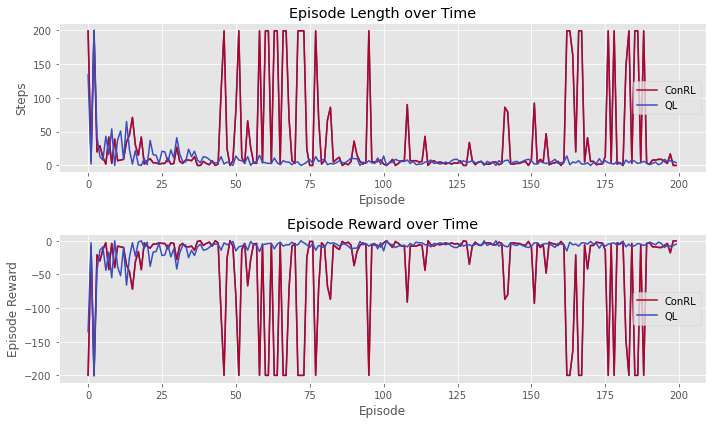

In [82]:
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 6))
ax1.set_prop_cycle('color', [plt.cm.coolwarm(i) for i in np.linspace(0, 1, 2)])
ax2.set_prop_cycle('color', [plt.cm.coolwarm(i) for i in np.linspace(0, 1, 2)])

ax1.plot(stats.episode_lengths)
rm = pd.Series(stats.episode_lengths).rolling(10).mean()
ax1.plot(stats.episode_lengths, label='ConRL')
ax1.plot(stats_q.episode_lengths, label='QL')
ax1.set_xlabel("Episode")
ax1.set_ylabel("Steps")
ax1.set_title("Episode Length over Time")
ax1.legend()

ax2.plot(stats.episode_rewards)
rm = pd.Series(stats.episode_rewards).rolling(10).mean()
ax2.plot(stats.episode_rewards, label='ConRL')
ax2.plot(stats_q.episode_rewards,  label='QL')

ax2.set_xlabel("Episode")
ax2.set_ylabel("Episode Reward")
ax2.set_title("Episode Reward over Time")
ax2.legend()

fig.tight_layout()

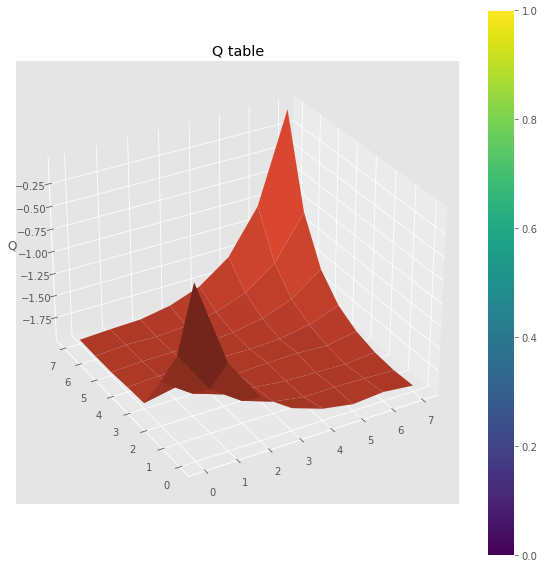

In [165]:
q = np.reshape(q_agent.Q, env_shape + (action_size, ))
cr = np.reshape(conrl.support.Q, env_shape + (action_size, ))

x_range = np.arange(0, env_shape[0])
y_range = np.arange(0, env_shape[1])
X, Y = np.meshgrid(x_range, y_range)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, np.max(cr, axis=2), rstride=1, cstride=1, vmin=-1.0, vmax=1.0)
ax.set_zlabel('Q')
ax.set_title("Q table")
ax.view_init(ax.elev, -120)
fig.colorbar(surf)
fig.tight_layout()
plt.show()

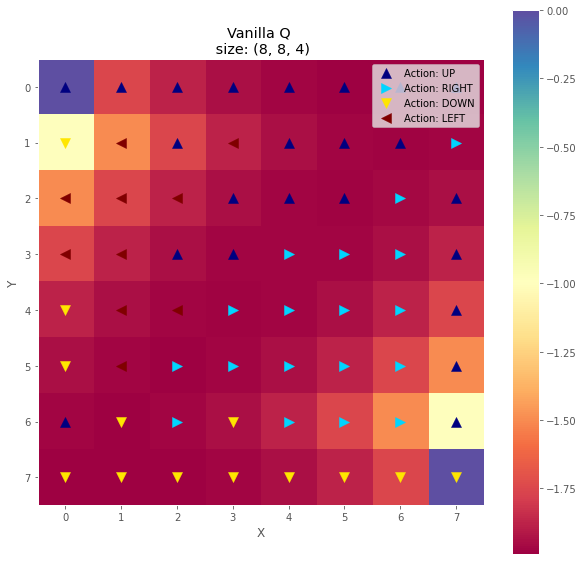

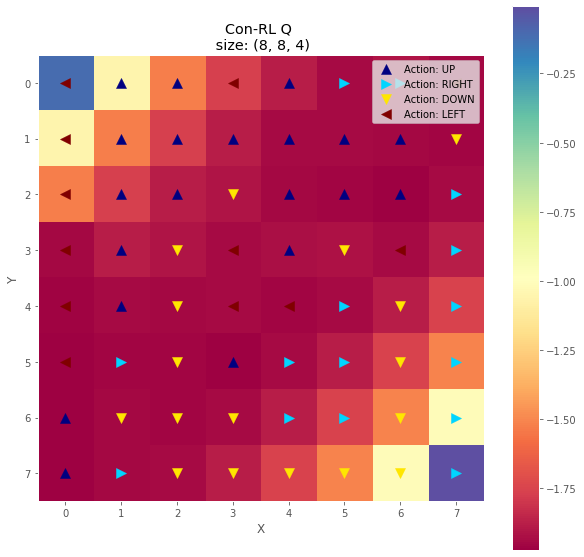

In [151]:
act_symbol = {
    0:  "^",
    1: ">",
    2: "v",
    3: "<"
}

act_color = [plt.cm.jet(i) for i in np.linspace(0, 1, 4)]

act_dict = {
    0: "UP",
    1: "RIGHT",
    2: "DOWN",
    3: "LEFT"
}

def plot_q_table(q_table, title="Q-table"):
    """Visualize max Q-value for each state and corresponding action."""
    q_image = np.max(q_table, axis=2)       # max Q-value for each state
    q_actions = np.argmax(q_table, axis=2)  # best action for each state

    fig, ax = plt.subplots(figsize=(10, 10))
    cax = ax.imshow(q_image, cmap='Spectral')
    cbar = fig.colorbar(cax)

    for action in np.unique(q_actions):
        x, y = np.where(q_actions==action)
        ax.scatter(x, y, label='Action: {}'.format(act_dict[action]), marker=act_symbol[action], s=10**2, c=[act_color[action]])
            
    ax.grid(False)
    ax.set_title("{} \n size: {}".format(title, q_table.shape))
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.legend()


plot_q_table(q, "Vanilla Q")
plot_q_table(cr, "Con-RL Q")

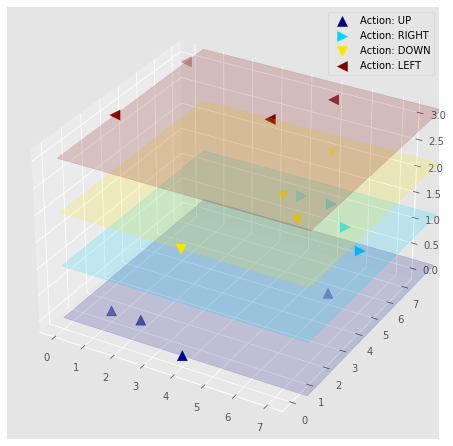

In [152]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Rectangle, PathPatch
import mpl_toolkits.mplot3d.art3d as art3d

fig = plt.figure(figsize=(6,6))
ax = fig.add_axes([0,0,1,1], projection='3d')

for i in range(4):
    x, y = np.unravel_index(conrl.mlgng[i].g.vp.pos.get_2d_array(pos=[0])[0].astype(int), env_shape)
    ax.scatter(x, y, i, marker=act_symbol[i], s=100, c=[act_color[i]], label="Action: {}".format(act_dict[i]))

    p = Rectangle((0,0), env_shape[0], env_shape[1], color=act_color[i], alpha=0.18)
    ax.add_patch(p)
    art3d.pathpatch_2d_to_3d(p, z=i, zdir="z")
    
    # plot connection lines
    # ax.plot([x[0],y[0],x[0]],[y[0],x[0],y[0]],[0.4,0.9,1.6], color="k")
    # ax.plot([x[2],y[2],x[2]],[y[2],x[2],y[2]],[0.4,0.9,1.6], color="k")
    ax.set_aspect('auto')

#ax.view_init(elev=15., azim=60)
plt.legend()
plt.show()

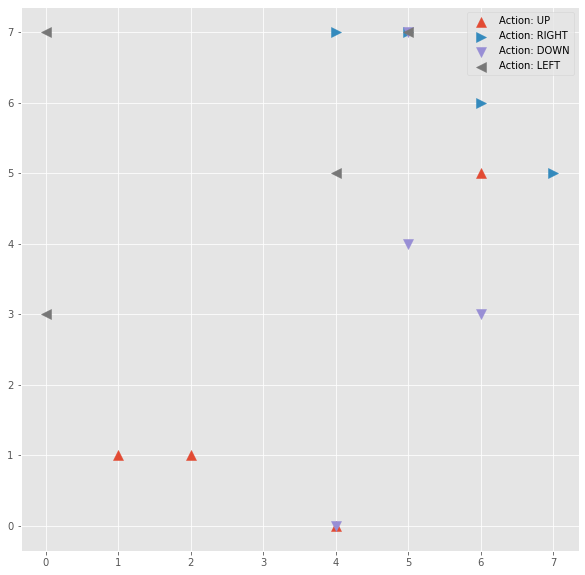

In [153]:
fig, ax = plt.subplots(figsize=(10, 10))
# Plot discretization as a grid
ax.grid(True)
for i in range(4):
    x, y = np.unravel_index(conrl.mlgng[i].g.vp.pos.get_2d_array(pos=[0]).astype(int), [8, 8])
    ax.scatter(x, y, label='Action: {}'.format(act_dict[i]), marker=act_symbol[i], s=10**2)
    ax.legend()


In [55]:
conrl.mlgng.stats()

> Layer:  0
Iterations:  137
Graph properties: 
<Graph object, undirected, with 4 vertices and 3 edges, 4 internal vertex properties, 1 internal edge property, at 0x7f4b44227d30>
> Layer:  1
Iterations:  187
Graph properties: 
<Graph object, undirected, with 4 vertices and 3 edges, 4 internal vertex properties, 1 internal edge property, at 0x7f4b3971acc0>
> Layer:  2
Iterations:  329
Graph properties: 
<Graph object, undirected, with 4 vertices and 2 edges, 4 internal vertex properties, 1 internal edge property, at 0x7f4b397d3e10>
> Layer:  3
Iterations:  66
Graph properties: 
<Graph object, undirected, with 4 vertices and 3 edges, 4 internal vertex properties, 1 internal edge property, at 0x7f4b39929eb8>


In [56]:
# MLGNG chosen at the beginning??? Something wrong with the action selection, mlgng should be chosen later on

Text(0, 0.5, 'Reward')

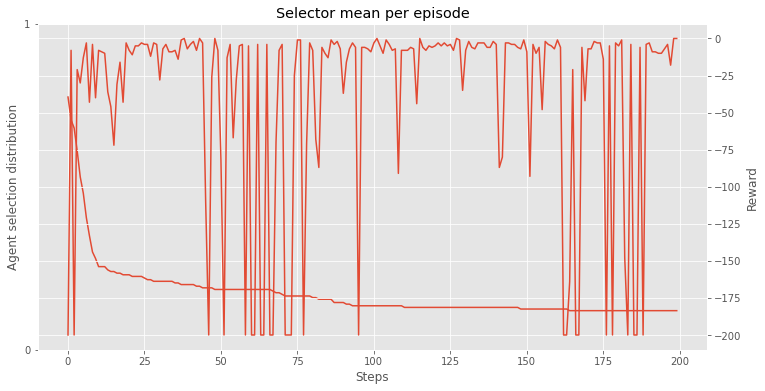

In [57]:
fig, ax = plt.subplots(figsize=(12, 6))
df = pd.DataFrame(stats.selector_dist)
ax.plot(df.mean())
ax.set_title("Selector mean per episode")
plt.yticks([0, 1])
plt.xlabel("Steps")
ax.set_ylabel("Agent selection distribution")

ax2 = ax.twinx()
ax2.plot(stats.episode_rewards)
ax2.set_ylabel("Reward")

Text(0, 0.5, 'Agent')

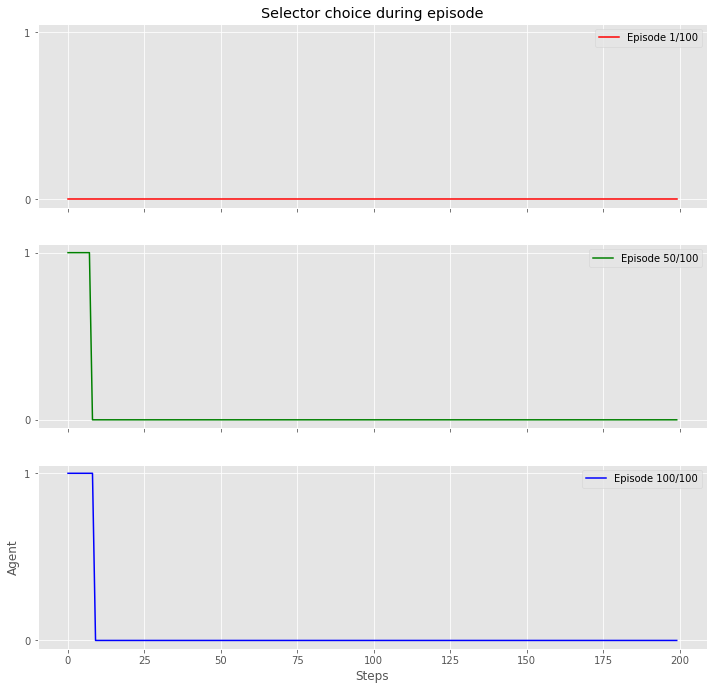

In [58]:
fig, ax = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(12, 11.5))


ax[0].plot(stats.selector_dist[0], color="r", label="Episode 1/100")
ax[0].legend()
ax[1].plot(stats.selector_dist[49], color="g", label="Episode 50/100")

ax[1].legend()
ax[2].plot(stats.selector_dist[99], color="b", label="Episode 100/100")
ax[2].legend()

ax[0].set_title("Selector choice during episode")
plt.yticks([0, 1])
plt.xlabel("Steps")
plt.ylabel("Agent")

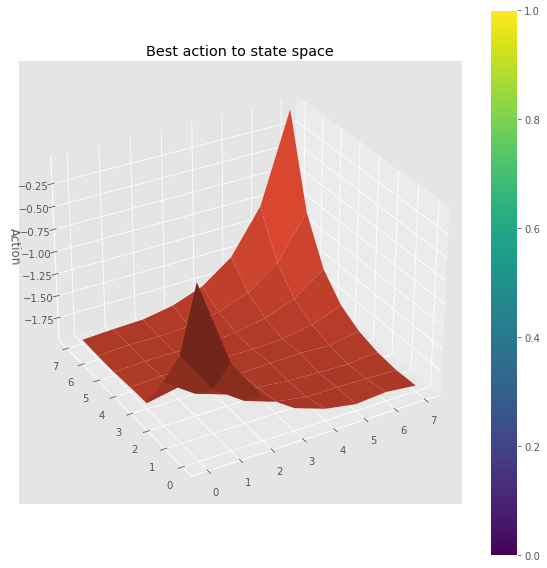

In [28]:
from collections import defaultdict

states = np.arange(8*8)
state_actions = defaultdict(lambda: [])
for state in states:
    best_a, _, _, _ = conrl._simple_action_selector(state)
    state_actions[best_a].append(state)

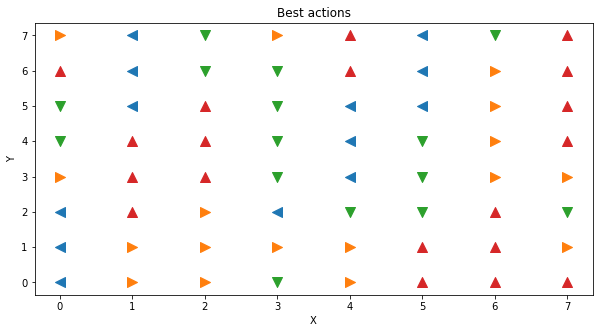

In [30]:


fig = plt.figure(figsize=(10,5))

for k, v in state_actions.items():
    x, y = np.unravel_index(v, (8,8))
    plt.scatter(x, y, label='Action: {}'.format(k), marker=act_dict[k], s=10**2)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("Best actions")